In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Read the data
X = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
X_test_full = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')


In [2]:
# Add initial helper function for estimating accuracy
def get_score(pipeline, n_folds=3):
    """Return the average MAE over n_folds CV folds of XGBoost model.
    
    Keyword argument:
    pipeline == a sklearn pipeline
    n_folds == the number of CV folds
    """
    scores = -1 * cross_val_score(pipeline, X, y, cv=n_folds, scoring='neg_mean_absolute_error')
    return scores.mean()

In [3]:
X.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [4]:
X.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# numerical 
X.dtypes[X.dtypes != 'object']

MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

# Data Exploration
Exploring the data using scatter plots to identify outliers. 

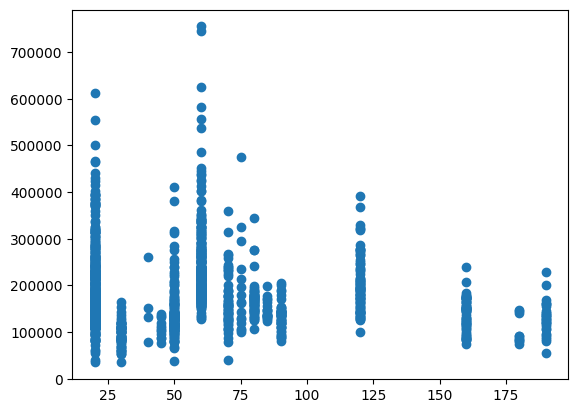

In [7]:
# This is more a categorical data point -- TODO handle this
plt.scatter(x='MSSubClass', y='SalePrice', data=X)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


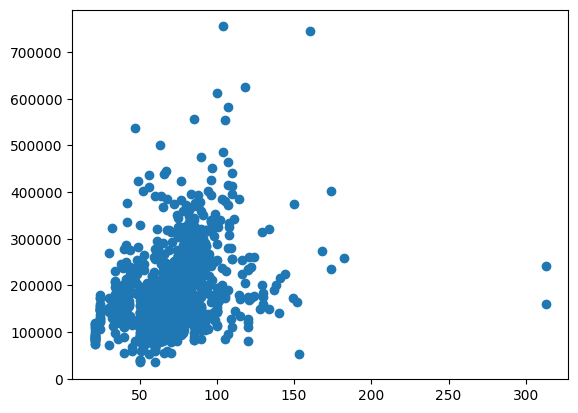

In [8]:
plt.scatter(x='LotFrontage', y='SalePrice', data=X)
X.query('LotFrontage > 300') # Outliers: 935, 1299

Id
385      4.268474
458      4.280500
770      4.308262
1397     4.678682
1299     5.348867
452      6.037793
707     10.486449
250     14.881285
336     15.448542
314     20.518273
Name: LotArea, dtype: float64

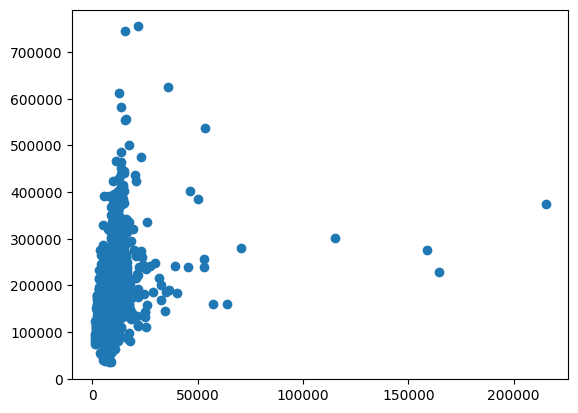

In [9]:
plt.scatter(x='LotArea', y='SalePrice', data=X)
X.query('LotArea > 100000')
stats.zscore(X['LotArea']).sort_values().tail(10)
# Outliers: 250, 314, 336, 707

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


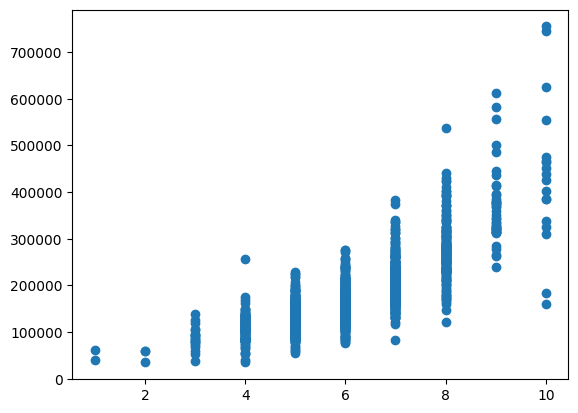

In [10]:
plt.scatter(x='OverallQual', y='SalePrice', data=X)
X.query('OverallQual == 10 and SalePrice < 200000') # Outliers: 524, 1299
# TODO should this and the following be handled the same as other numerical?

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
379,20,RL,88.0,11394,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,6,2010,New,Partial,394432


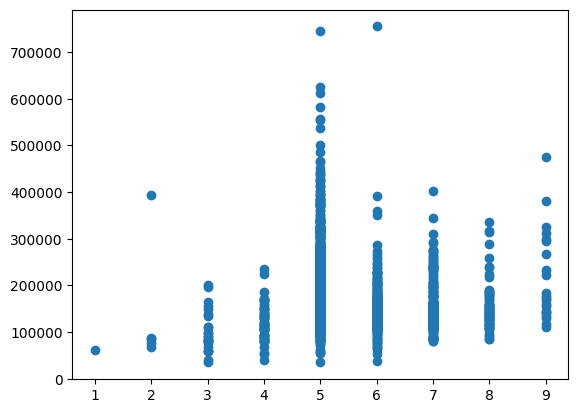

In [11]:
plt.scatter(x='OverallCond', y='SalePrice', data=X)
X.query('OverallCond == 2 and SalePrice > 375000') # Outlier: 379 
# Sale Price outliers: 692 (OverallCond == 6), 1183 (OverallCond == 5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


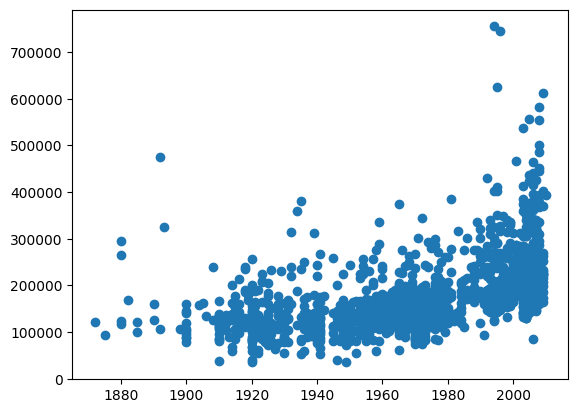

In [12]:
plt.scatter(x='YearBuilt', y='SalePrice', data=X)
X.query('YearBuilt < 1900 and SalePrice > 400000') # Outlier: 186

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000


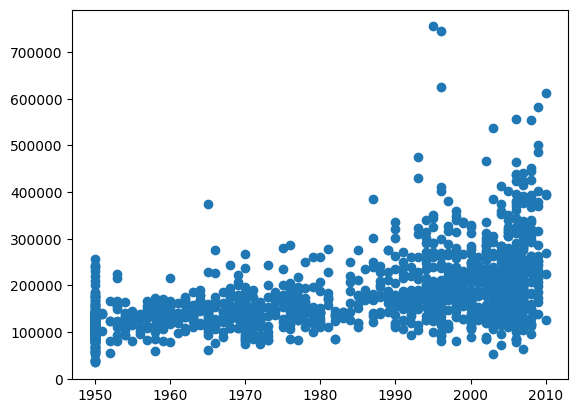

In [13]:
plt.scatter(x='YearRemodAdd', y='SalePrice', data=X)
X.query('YearRemodAdd < 1970 and SalePrice > 300000') # Outlier: 314
# stats.zscore(X['YearRemodAdd']).sort_values().tail(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
298,60,FV,66.0,7399,Pave,Pave,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,239000


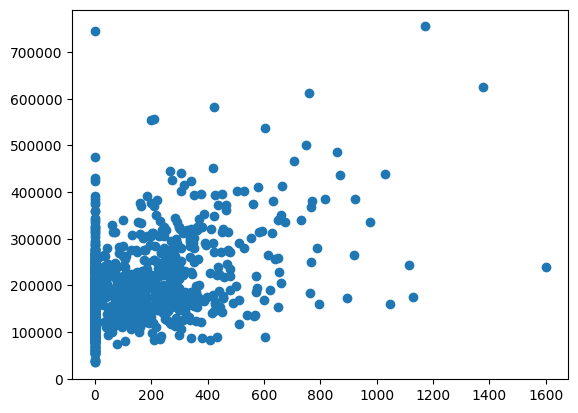

In [14]:
plt.scatter(x='MasVnrArea', y='SalePrice', data=X)
X.query('MasVnrArea > 1500') # Outlier: 298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


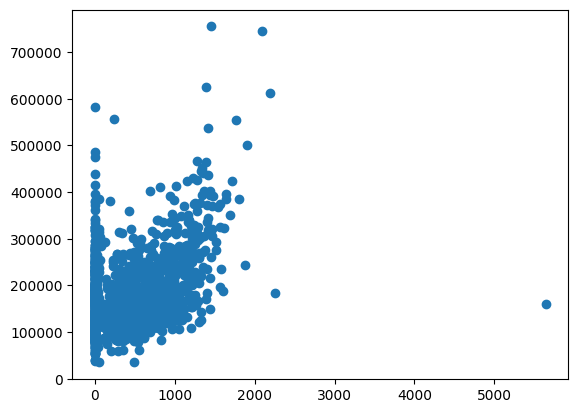

In [15]:
plt.scatter(x='BsmtFinSF1', y='SalePrice', data=X)
X.query('BsmtFinSF1 > 5000') # Outliers: 1299

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000


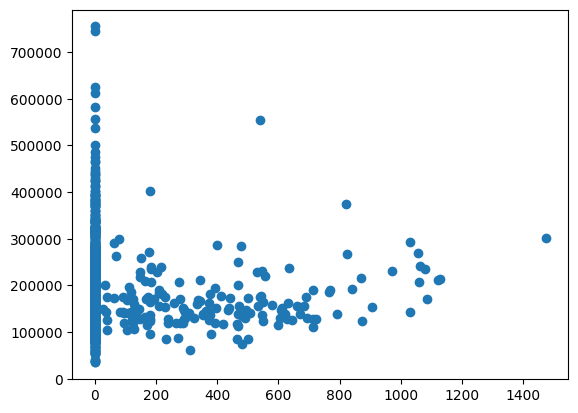

In [16]:
plt.scatter(x='BsmtFinSF2', y='SalePrice', data=X)
X.query('BsmtFinSF2 > 1400') # Outlier: 323 (this one might be ok)
X.query('BsmtFinSF2 > 400 and SalePrice > 500000') # Outlier: 441
# stats.zscore(X['BsmtFinSF2']).sort_values().tail(15) # there are a lot of high zscores here

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


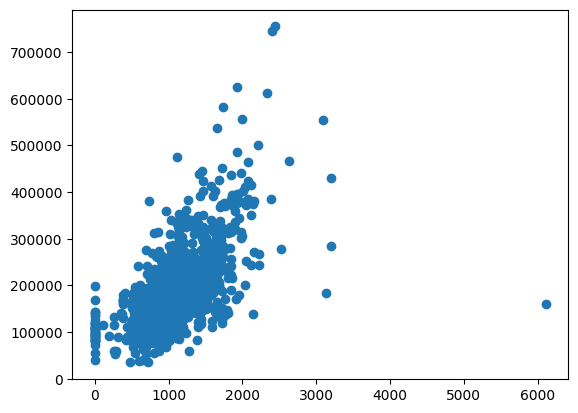

In [17]:
plt.scatter(x='TotalBsmtSF', y='SalePrice', data=X)
X.query('TotalBsmtSF > 6000') # Outlier: 1299

Id
844     2.790845
964     2.790845
769     2.872345
351     2.947054
933     3.028554
138     3.033082
799     3.076096
775     3.096471
497     3.173444
1268    3.248152
582     3.338708
679     3.347764
279     3.517556
478     3.590001
225     4.004295
Name: BsmtUnfSF, dtype: float64

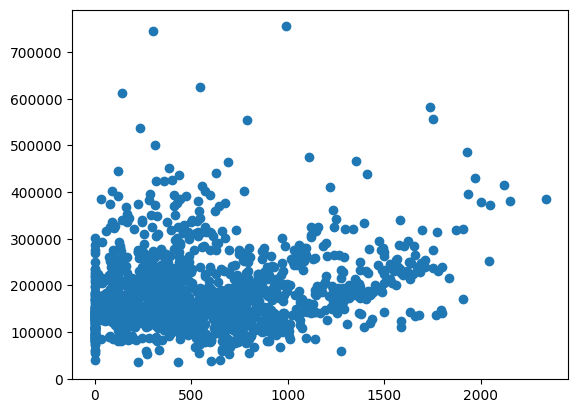

In [18]:
plt.scatter(x='BsmtUnfSF', y='SalePrice', data=X)
stats.zscore(X['BsmtUnfSF']).sort_values().tail(15)
# TODO not sure if any should be removed here, seems like maybe not a good indicator?

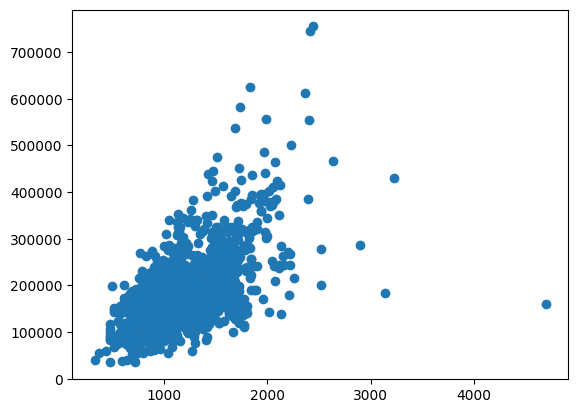

In [19]:
plt.scatter(x='1stFlrSF', y='SalePrice', data=X)

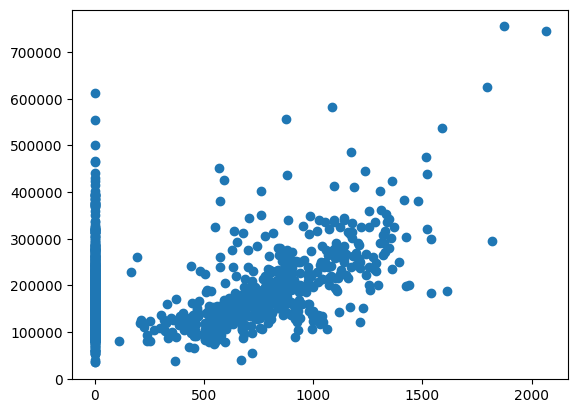

In [20]:
plt.scatter(x='2ndFlrSF', y='SalePrice', data=X)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


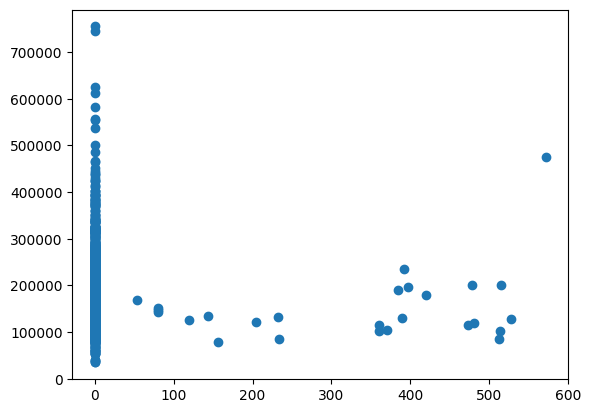

In [21]:
plt.scatter(x='LowQualFinSF', y='SalePrice', data=X)
X.query('LowQualFinSF > 550') # Outlier: 186

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


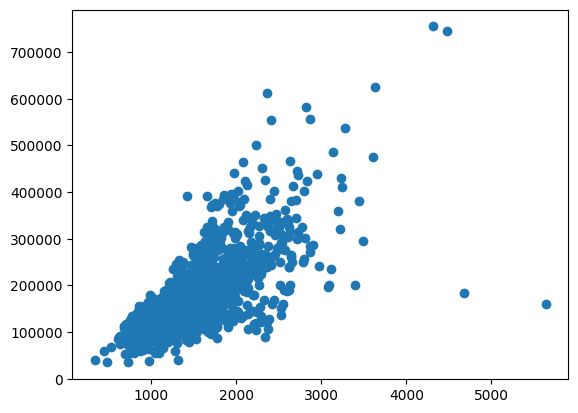

In [22]:
plt.scatter(x='GrLivArea', y='SalePrice', data=X)
X.query('GrLivArea > 4500 and SalePrice < 250000') # Outliers: 524, 1299

array([ 1.10781015, -0.81996437,  3.03558466,  4.96335918])

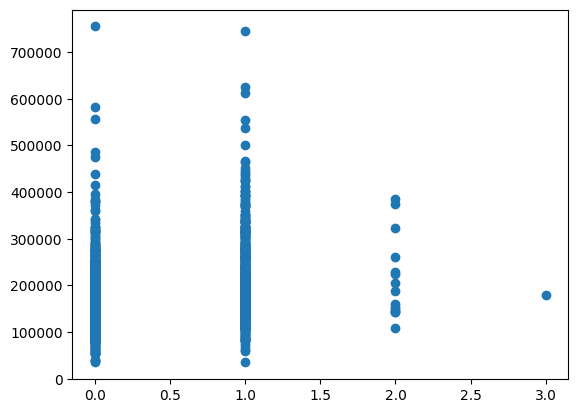

In [23]:
plt.scatter(x='BsmtFullBath', y='SalePrice', data=X)
X.query('BsmtFullBath == 3') # 739
stats.zscore(X['BsmtFullBath']).unique() # the 2.0 have a high zscore, unsure how to handle

array([-0.24106104,  3.94880935,  8.13867973])

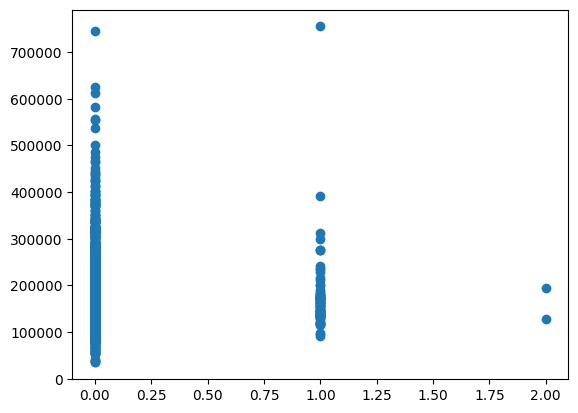

In [24]:
plt.scatter(x='BsmtHalfBath', y='SalePrice', data=X)
X.query('BsmtHalfBath == 2') # 598, 955 # High z score, should probably remove
stats.zscore(X['BsmtHalfBath']).unique()

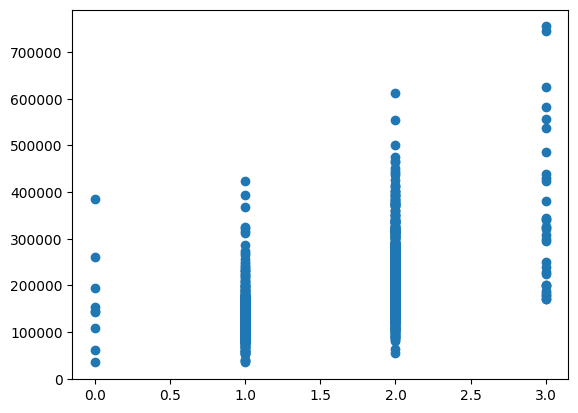

In [25]:
plt.scatter(x='FullBath', y='SalePrice', data=X)

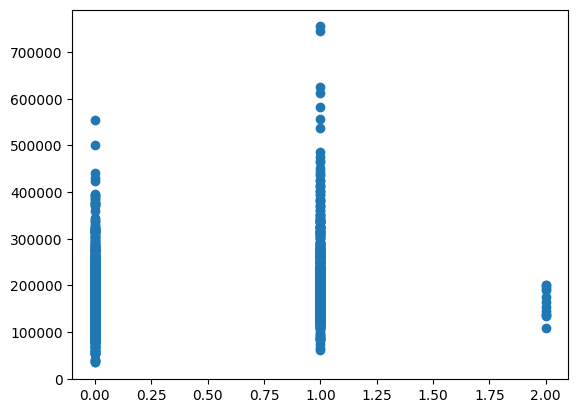

In [26]:
plt.scatter(x='HalfBath', y='SalePrice', data=X)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


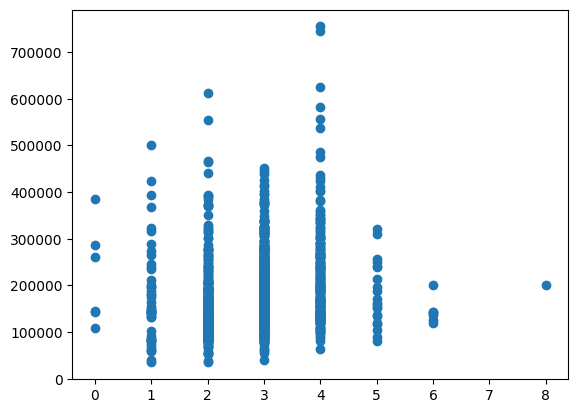

In [27]:
plt.scatter(x='BedroomAbvGr', y='SalePrice', data=X)
X.query('BedroomAbvGr == 8') # Outlier: 636

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
49,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
810,75,RM,90.0,8100,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,MnPrv,NaN,0,11,2009,WD,Normal,106000


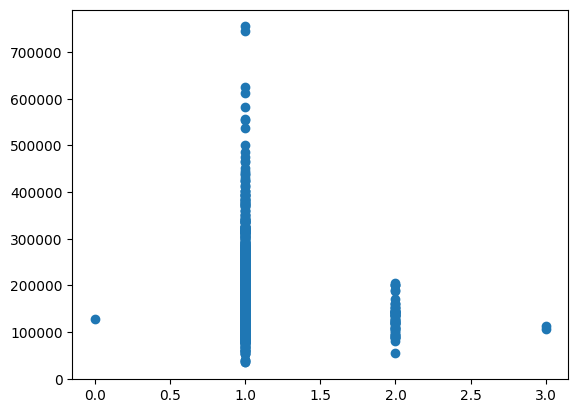

In [28]:
plt.scatter(x='KitchenAbvGr', y='SalePrice', data=X)
X.query('KitchenAbvGr == 3') # Outliers: 49, 810

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


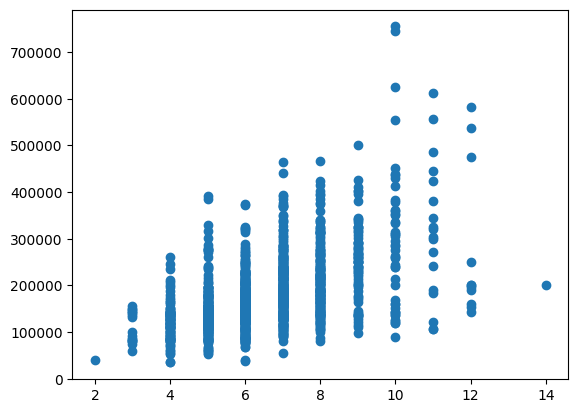

In [29]:
plt.scatter(x='TotRmsAbvGrd', y='SalePrice', data=X)
X.query('TotRmsAbvGrd == 14') # Outlier: 636

array([-0.95122649,  0.60049493,  2.15221636,  3.70393778])

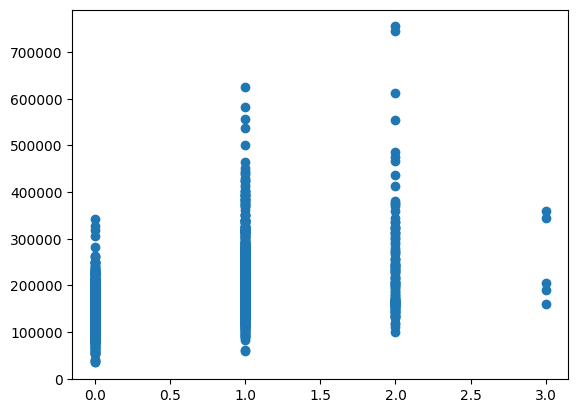

In [30]:
plt.scatter(x='Fireplaces', y='SalePrice', data=X)
stats.zscore(X['Fireplaces']).unique() # 3 Fireplaces: 3.7
# 3 Fireplaces: 167, 310, 606, 643, 1299 - not sure if these should be removed

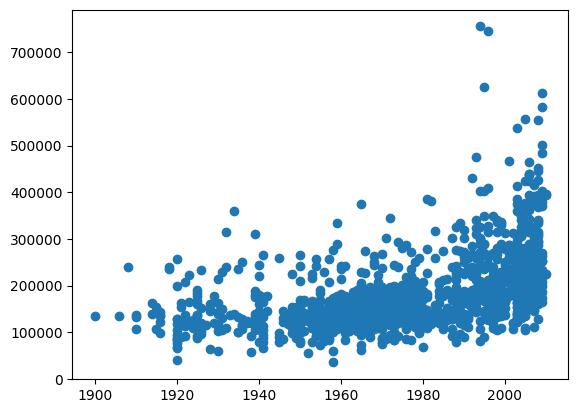

In [31]:
plt.scatter(x='GarageYrBlt', y='SalePrice', data=X)

array([ 0.31172464,  1.65030694, -1.02685765, -2.36543995,  2.98888924])

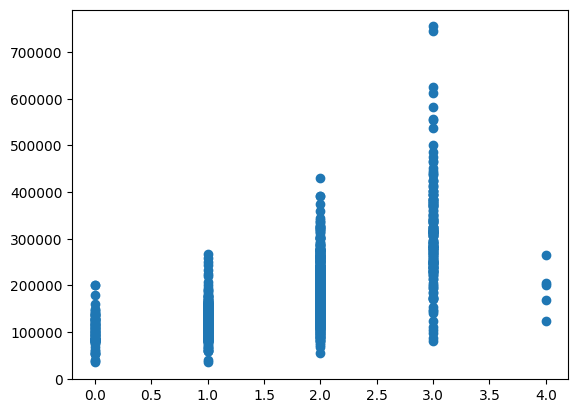

In [32]:
plt.scatter(x='GarageCars', y='SalePrice', data=X)
X.query('GarageCars == 4') # 421, 748, 1191, 1341, 1351 - think this is ok to leave in
stats.zscore(X['GarageCars']).unique()

Id
1229    2.709098
271     2.713777
1418    2.788637
665     3.092757
179     3.242477
826     3.495131
1062    3.626136
1191    4.131443
582     4.290521
1299    4.421526
Name: GarageArea, dtype: float64

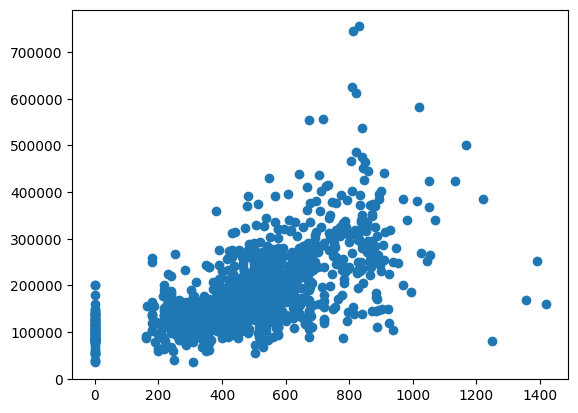

In [33]:
plt.scatter(x='GarageArea', y='SalePrice', data=X)
stats.zscore(X['GarageArea']).sort_values().tail(10)
# High Z Score: 1299, 582, 1191, maybe 1062, 826

Id
962     3.637434
170     3.828981
65      3.844943
1424    3.924754
1211    4.315829
1314    4.579205
336     4.595168
1069    5.058072
1460    5.121921
54      6.087635
Name: WoodDeckSF, dtype: float64

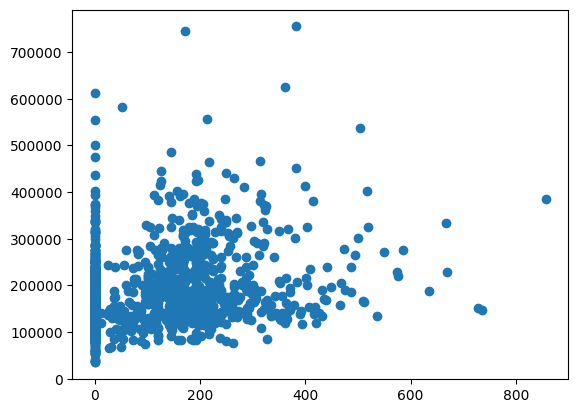

In [34]:
plt.scatter(x='WoodDeckSF', y='SalePrice', data=X)
stats.zscore(X['WoodDeckSF']).sort_values().tail(10)
# High score (look into these): 54, 1460, 1069, 336

Id
808     4.006136
646     4.006136
997     4.111823
736     4.443982
876     4.791239
524     5.425361
855     5.606538
584     6.874782
496     7.191843
1329    7.554198
Name: OpenPorchSF, dtype: float64

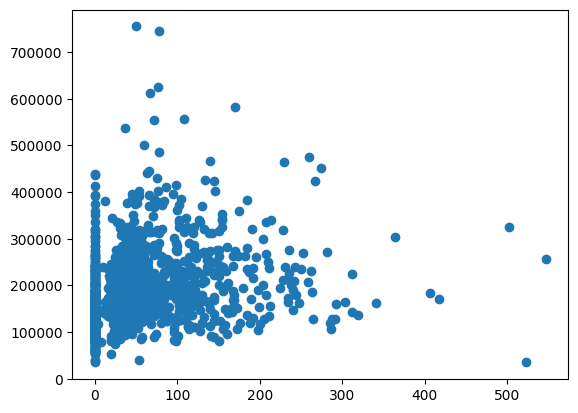

In [35]:
plt.scatter(x='OpenPorchSF', y='SalePrice', data=X)
stats.zscore(X['OpenPorchSF']).sort_values().tail(10)
# X.query('OpenPorchSF > 325') # Outliers: 496, 524, 584, 855, 1329, 736, 876
# Note: the tutorial only removed 496 here

Id
1153    4.223460
1327    4.321663
497     4.403498
631     4.436233
359     4.452600
1361    4.567169
940     4.845410
1198    5.041815
748     5.958372
198     8.675309
Name: EnclosedPorch, dtype: float64

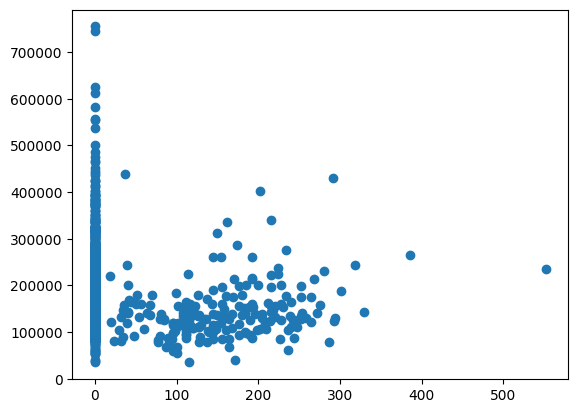

In [36]:
plt.scatter(x='EnclosedPorch', y='SalePrice', data=X)
stats.zscore(X['EnclosedPorch']).sort_values().tail(10)
# X.query('EnclosedPorch > 350') # Outliers: 198, 748
# Note: the tutorial only removes 198 here but there are some other high zscores

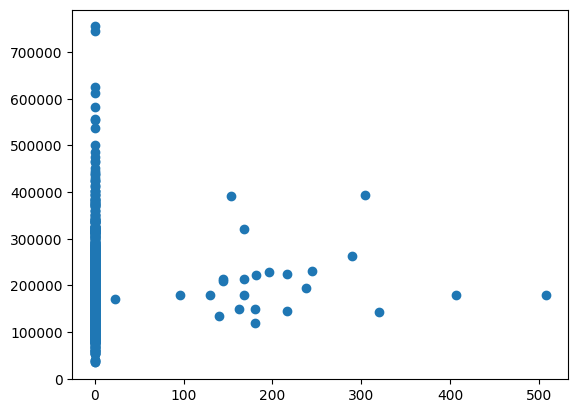

In [37]:
plt.scatter(x='3SsnPorch', y='SalePrice', data=X)
# TODO we could maybe chance this to has vs doesn't have

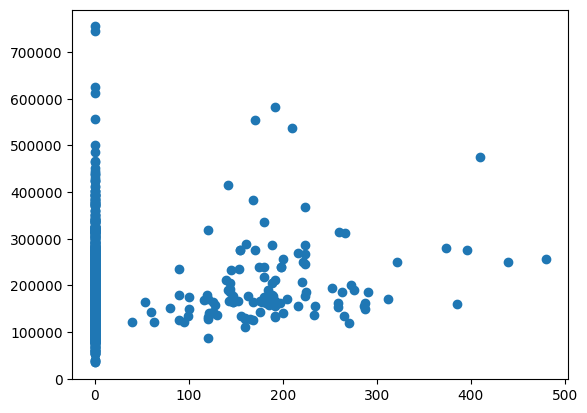

In [38]:
plt.scatter(x='ScreenPorch', y='SalePrice', data=X)

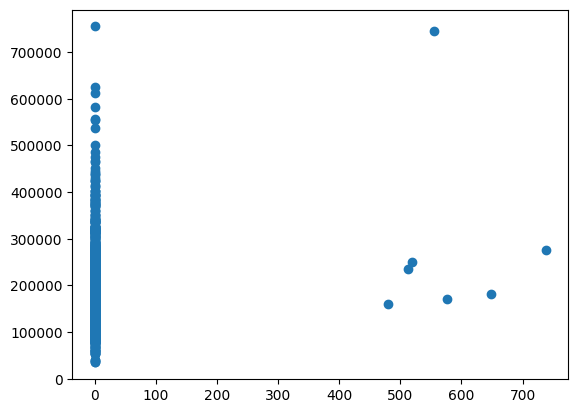

In [39]:
plt.scatter(x='PoolArea', y='SalePrice', data=X)

In [40]:
# TODO: skipping misc features

After we've looked at all of our numerical values, we'll decide which ones to remove. I have two lists for now -- "values" with likely outliers, and "undecided" with values that I'm undecided if they should be removed. 

In [41]:
values =  [49, 186, 198, 250, 298, 314, 336, 379, 441, 496, 524, 582, 598, 636, 707, 739, 810, 935, 955, 1191, 1299, 1329]
print(len(values)) # => 22
undecided = [54, 323, 584, 748, 826, 855, 1062, 1069, 1460]

# Remove rows with missing target
X.dropna(axis=0, subset=['SalePrice'], inplace=True)

# Remove rows with outliers 
X.drop(values)

22


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


Next we need to handle missing values

In [42]:
pd.DataFrame(X.isnull().sum().sort_values(ascending=False)).head(20)
# Drop PoolQC
# Drop MiscFeature (could look into )

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81


In [43]:
X['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [44]:
def replace_empty_value(col, value):
    """Replaces empty in train and test set in the provided column 
    name with the provided value
    
    col = the column name
    value = the replacement value
    """
    X[col].fillna(value, inplace=True)
    X_test_full[col].fillna(value, inplace=True)

In [45]:
replace_empty_value('Alley', 'None')

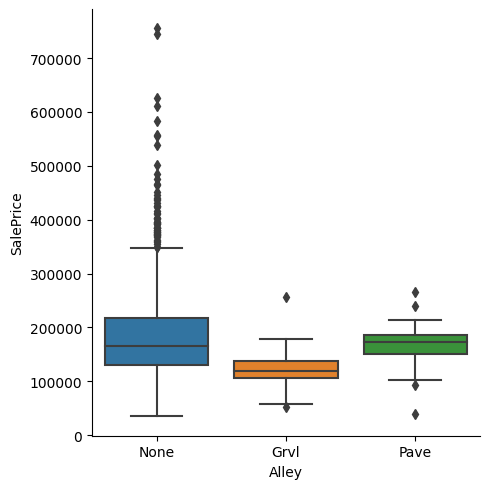

In [46]:
sns.catplot(data=X, x='Alley', y='SalePrice', kind='box')

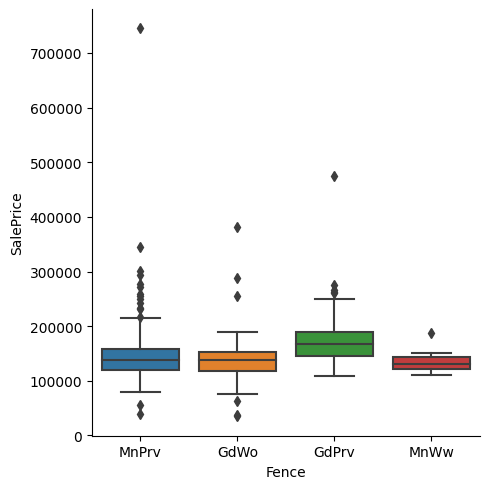

In [47]:
X['Fence'].unique()
sns.catplot(data=X, x='Fence', y='SalePrice', kind='box')
replace_empty_value('Fence', 'None')

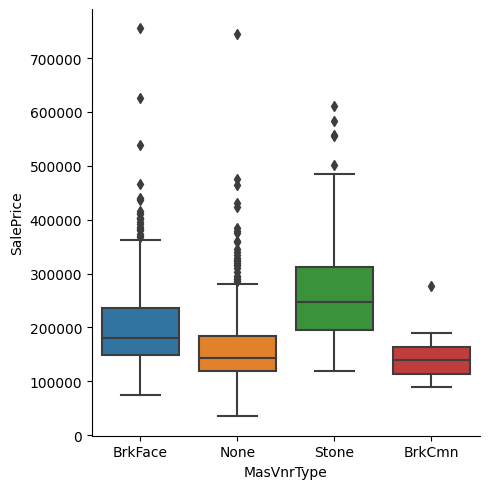

In [48]:
replace_empty_value('MasVnrType', 'None')
replace_empty_value('MasVnrArea', 0)
sns.catplot(data=X, x='MasVnrType', y='SalePrice', kind='box')

In [49]:
X['FireplaceQu'].unique()
replace_empty_value('FireplaceQu', 'None')

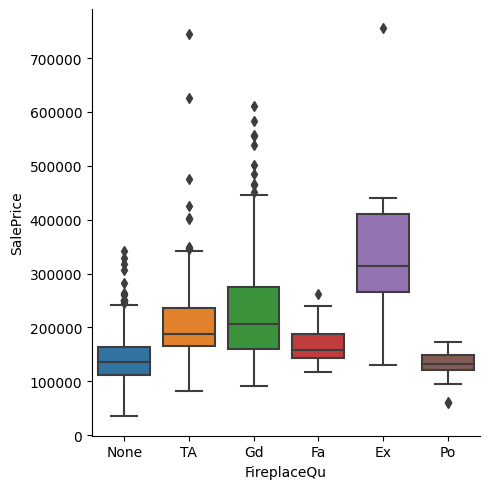

In [50]:
sns.catplot(data=X, x='FireplaceQu', y='SalePrice', kind='box')

In [51]:
replace_empty_value('LotFrontage', 0)

In [52]:
X['GarageYrBlt'].corr(X['YearBuilt']) # Will drop due to strong correlation

0.8256674841743421

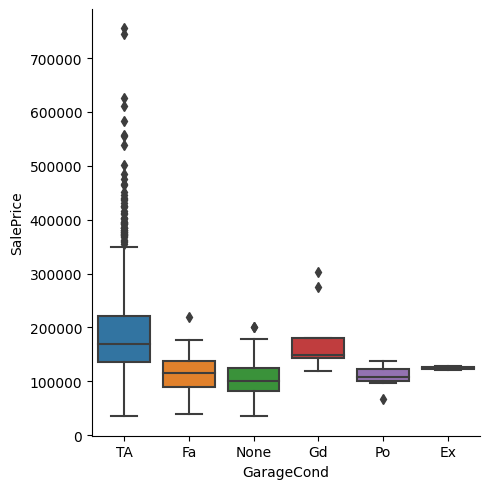

In [53]:
X['GarageCond'].unique()
replace_empty_value('GarageCond', 'None')
sns.catplot(data=X, x='GarageCond', y='SalePrice', kind='box')

In [54]:
# Separate target from predictors
# y = X.SalePrice
# X.drop(['SalePrice'], axis=1, inplace=True)